In [1]:
import jax
import jax.numpy as np
import numpy as onp
import flax.linen as nn
import optax
from tqdm import trange, tqdm

import matplotlib.pyplot as plt

from typing import Sequence, Callable
from functools import partial

## Plummer checks

Some sanity checks with CBE on Plummer profile.

In [2]:
def phi_plummer(pos, a=1., G=1., M=1.):
    """ Plummer potential; `pos` is a vector of shape (3,), a is the scale radius
    """
    x, y, z = pos
    return -G * M / (np.sqrt(x**2 + y**2 + z**2 + a**2))

def phi_nfw(pos, a=1., G=1., M=1.):
    """ NFW potential; `pos` is a vector of shape (3,), a is the scale radius
    """
    r = np.linalg.norm(pos)
    return -G * M * np.log(1 + r / a) / r

# Plummer Distribution Function
def f_plummer(xv, a=1., G=1., M=1.):
    """ Plummer distribution function; `xv` is a vector of shape (6,), `a` is the scale radius
    """
    x, y, z, vx, vy, vz = xv
    phi = -phi_plummer(np.array([x, y, z]), a=a, G=G, M=M)
    q = (1/2) * (vx**2 + vy**2 + vz**2)
    return np.where(phi > q, (24 * np.sqrt(2) * np.pi**3 * a**6 * G**3 * M**3)**(-1) * (phi - q)**(7/2), 0)

Make sure CBE is satisfied:

In [3]:
# Test values
xv = np.array([12., 3., 4., .1, .3, .1])

# Gradient of f_plummer wrt xv
df_dxv = jax.jacobian(lambda xv: f_plummer(xv, a=1.))(xv)

# Gradient of phi_plummer wrt (x, y, z)
dPhi_dx = jax.jacobian(lambda pos: phi_plummer(pos, a=1.))(xv[:3])

# v * df/dx - dPhi/dx * df/dv
vlasov = np.dot(xv[3:], df_dxv[:3]) + np.dot(-dPhi_dx, df_dxv[3:])
vlasov

Array(0., dtype=float32)

## Generate phase-space samples

In [4]:
import emcee

# Use emcee to sample from the distribution function
sampler = emcee.EnsembleSampler(nwalkers=32, ndim=6, log_prob_fn=lambda xv: np.log(f_plummer(xv, a=1.)))
sampler.run_mcmc(onp.random.randn(32, 6) * 5e-5, 2500, progress=True);

100%|██████████| 2500/2500 [00:28<00:00, 87.07it/s]


In [5]:
n_samples = 100000

# Get flattened chain; reject burn-in
xv_samples = sampler.get_chain(discard=500, flat=True)
xv_samples = xv_samples[-n_samples:]

# For base distribution, use mean and std of samples
xv_mean = np.mean(xv_samples, axis=0)
xv_std = np.std(xv_samples, axis=0)

pos, vel = xv_samples[:, :3], xv_samples[:, 3:]

print(pos.shape, vel.shape)

(64000, 3) (64000, 3)


Sanity check: Plummer density computed via Poisson.

In [6]:
def rho_plummer_poisson(pos, G=1.):
    """ Plummer density profile; compute using Poisson's equation
    """
    hess = jax.jacobian(jax.jacobian(lambda pos: phi_plummer(pos, a=1.)))(pos)
    laplacian = np.trace(hess)
    return laplacian / (4 * np.pi * G)

def rho_plummer(r, a=1., M=1.):
    """ Plummer density profile
    """
    return (3 * M) / (4 * np.pi * a**3) * (1 + r**2 / a**2)**(-5/2)

idx = 4
rho_plummer_poisson(pos[idx]), rho_plummer(np.linalg.norm(pos[idx]))


(Array(0.09467569, dtype=float32), Array(0.09467568, dtype=float32))

Plot for a few values of `a`.

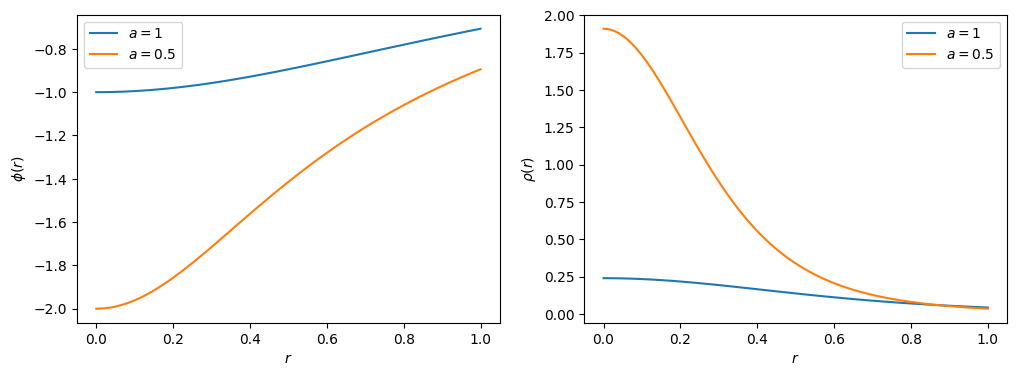

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

phi_radial = lambda r, a: phi_plummer([0., 0., r], a=a)
r_ary = np.linspace(0., 1., 100)

# Potential
ax[0].plot(r_ary, [phi_radial(r, 1.) for r in r_ary], label=r"$a=1$")
ax[0].plot(r_ary, [phi_radial(r, 0.5) for r in r_ary], label=r"$a=0.5$")
ax[0].set_xlabel(r"$r$")
ax[0].set_ylabel(r"$\phi(r)$")
ax[0].legend()    

# Density
ax[1].plot(r_ary, [rho_plummer(r, a=1.) for r in r_ary], label=r"$a=1$")
ax[1].plot(r_ary, [rho_plummer(r, a=0.5) for r in r_ary], label=r"$a=0.5$")
ax[1].set_xlabel(r"$r$")
ax[1].set_ylabel(r"$\rho(r)$")
ax[1].legend()

## Leapfrog integration and potential $\Phi(x, t)$

In [76]:
import jax
import jax.numpy as np

@partial(jax.jit, static_argnums=(2,3,))
def leapfrog_step(pos, vel, potential_func, dt):
    """
    Implements a single step of the leapfrog integration method.

    Args:
        pos (jax.numpy.ndarray): Array of particle positions. Should be in a length unit.
        vel (jax.numpy.ndarray): Array of particle velocities.
        potential_func (function): Function that computes the potential energy of the system.
        dt (float): Time step size.

    Returns:
        Tuple containing the new positions and velocities, and the Jacobian of the transformation.
    """

    # Compute the gradient of the potential energy function
    grad_potential = jax.grad(potential_func)

    # Compute the forces on the particles by evaluating the gradient of the potential energy
    vel_dot = -grad_potential(pos)

    # Update the velocities by half a time step
    vel_half = vel + vel_dot * (dt / 2.0)

    # Update the positions using the new velocities
    pos_new = pos + vel_half * dt

    # Compute the forces on the new positions
    forces_new = -grad_potential(pos_new)

    # Update the velocities using the new forces
    vel_new = vel_half + forces_new * (dt / 2.0)

    # Return the new positions and velocities, and the updated Jacobian derivatives as a tuple
    return pos_new, vel_new


In [209]:
class MLP(nn.Module):
    """A simple MLP (fully-connected neural network) parameterizing the potential."""

    feature_sizes: Sequence[int]
    activation: Callable[[np.ndarray], np.ndarray] = nn.gelu

    @nn.compact
    def __call__(self, x, t):
        
        phi0 = jax.vmap(phi_plummer, in_axes=(0,None))(np.atleast_2d(x), 1.)

        # x = (x ** 2).sum(axis=-1, keepdims=True)  # Radially symmetric potential
        x = np.concatenate([x, t], axis=-1)
        for features in self.feature_sizes[:-1]:
            x = nn.Dense(features)(x)
            x = self.activation(x)

        # No activation on final layer; unconstrained output, with zero init
        x = nn.Dense(self.feature_sizes[-1])(x)
        return phi0 + x

Initial potential.

Number of parameters: 9889


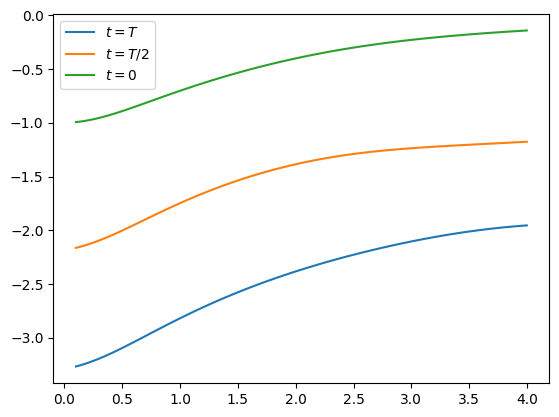

In [210]:
# T hparam
T = 10.0

# Initialize some random times, just to initialize MLP
rng = jax.random.PRNGKey(0)
t = jax.random.uniform(rng, (pos.shape[0], 1))

# Initialize MLP potential function
potential_mlp = MLP(feature_sizes=[96, 96, 1])

rng, _ = jax.random.split(rng)
params = potential_mlp.init(rng, pos, t)

param_count = sum(x.size for x in jax.tree_util.tree_leaves(params))
print(f"Number of parameters: {param_count}")

r_ary = np.linspace(0.1, 2 * pos.std(), 100)
phi_ary = [potential_mlp.apply(params, np.array([0.,0.,r]), np.array([T])) for r in r_ary]
plt.plot(r_ary, phi_ary, label=r"$t=T$")

phi_ary = [potential_mlp.apply(params, np.array([0.,0.,r]), np.array([T / 2.])) for r in r_ary]
plt.plot(r_ary, phi_ary, label=r"$t=T/2$")

phi_ary = [potential_mlp.apply(params, np.array([0.,0.,r]), np.array([0.])) for r in r_ary]
plt.plot(r_ary, phi_ary, label=r"$t=0$")

plt.legend()

In [211]:
def rho_poisson(pos, G=1.):
    """ Plummer density profile; compute using Poisson's equation
    """
    hess = jax.jacobian(jax.jacobian(lambda pos: potential_mlp.apply(params, np.array(pos), np.array([T]))))(pos)[0]
    laplacian = np.trace(hess)
    return laplacian / (4 * np.pi * G)

def rho_poisson_radial(r, G=1.):
    return rho_poisson(np.array([0.,0.,r]), G=G)

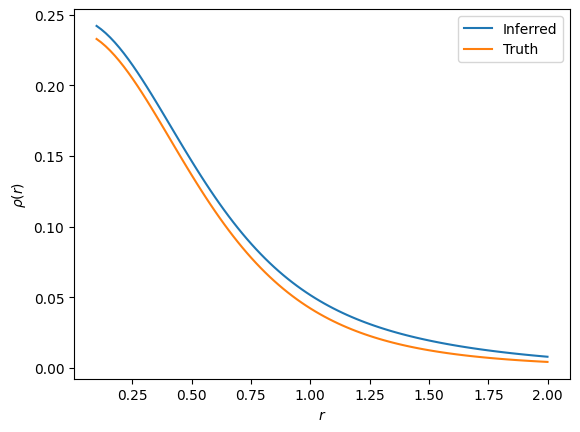

In [200]:
r_ary = np.linspace(0.1, 1. * pos.std(), 100)
plt.plot(r_ary, [rho_poisson_radial(r) for r in r_ary], label=r"Inferred")
plt.plot(r_ary, [rho_plummer(r, a=1.) for r in r_ary], label=r"Truth")
plt.xlabel(r"$r$")
plt.ylabel(r"$\rho(r)$")
plt.legend()

## Loss and fit

In [201]:
from functools import partial
from einops import repeat
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

In [203]:
n_dim = 3
n_leapfrog_steps = 50

@partial(jax.jit, static_argnums=(3,4,))
def loss_fn(params, pos, vel, T, n_leapfrog_steps):
    """ Loss function for simultaneous phase-space density estimation and CBE satisfaction.
    """

    # Apply leapfrog integration to transform to the base distribution 
    # T is defined as present time, 0 is the asymptotic past at which the phase space was Gaussian

    dt = T / n_leapfrog_steps

    def log_f_x_v(xv):

        pos, vel = np.split(xv, 2, axis=-1)

        def body_fn(carry, i):
            pos, vel = carry
            t = np.atleast_1d(T - i * dt)
            return leapfrog_step(pos, vel, lambda x: potential_mlp.apply(params, x, t)[0], -dt), None

        # Phase space coordinates in the base distribution
        (pos_base, vel_base), _ = jax.lax.scan(body_fn, (pos, vel), jax.numpy.arange(n_leapfrog_steps))

        # Base distribution is just a standard normal
        # We don't need to worry about det-Jacobian because it's unity for leapfrog
        base_dist = tfd.MultivariateNormalDiag(loc=xv_mean, scale_diag=xv_std)

        # Compute log-density
        log_prob = base_dist.log_prob(np.concatenate([pos_base, vel_base], axis=-1))

        return log_prob

    # Compute log-density log{f(x, v)} and its Jacobian for each example in the batch
    # Use vmap to apply log_prob_and_jacobian to each example in the batch
    # Density is calculated in the base distribution; f(x, v) = f_0(x_0, v_0), since the log-det-Jacobian is unity
    log_f_x_v, d_log_f_x_v_d_x_v  = jax.vmap(jax.value_and_grad(log_f_x_v))(np.concatenate([pos, vel], axis=-1))
    # log_f_x_v  = jax.vmap((log_f_x_v))(np.concatenate([pos, vel], axis=-1))

    # Get df/dx and df/dv from the log-Jacobian
    df_dx = d_log_f_x_v_d_x_v[..., :n_dim] * np.exp(log_f_x_v)[:, None]
    df_dv = d_log_f_x_v_d_x_v[..., n_dim:2 * n_dim] * np.exp(log_f_x_v)[:, None]

    # d_f_x_v_d_x_v = jax.vmap(jax.grad(f_plummer))(np.concatenate([pos, vel], axis=-1))
    # df_dx, df_dv = np.split(d_f_x_v_d_x_v, 2, axis=-1)

    # Get acceleration as the negative gradient of the potential
    # Use zero index because the potential is a scalar; jax.jacobian output is shape (n_batch, 1 ,3)
    vel_dot = -jax.vmap(jax.jacobian(potential_mlp.apply, argnums=1), in_axes=(None,0,0))(params, pos, T * np.ones((pos.shape[0], 1)))[:, 0, :]

    # # Get density using Poisson equation
    # def rho(pos):
    #     hess = jax.jacobian(jax.jacobian(lambda pos: potential_mlp.apply(params, np.array(pos), np.array([T]))))(pos)[0]
    #     laplacian = np.trace(hess)
    #     return laplacian / (4 * np.pi)
    
    # # Use a negative ReLU to regularize the density to be positive
    # rho_vals = jax.vmap(rho)(pos)

    # df/dt = -v df/dx - v_dot df/dv; regularize this quantity to be small
    df_dt = -(vel * df_dx + vel_dot * df_dv)

    # print(-log_f_x_v, np.log(np.abs(df_dt)))

    return -log_f_x_v.mean() + 1e4 * np.abs(df_dt).mean() 
    # return 1e5 * np.abs(df_dt).mean() 

In [204]:
loss = loss_fn(params, pos[:4], vel[:4], T, n_leapfrog_steps)
print(loss)

178.06


In [205]:
loss, grad = jax.value_and_grad(loss_fn)(params, pos[:4], vel[:4], T, n_leapfrog_steps)

print(f"Initial loss: {loss:.2f}")

Initial loss: 178.06


In [206]:
n_steps = 1000
n_batch = 128
key = jax.random.PRNGKey(42)

opt = optax.adamw(learning_rate=1e-4)
opt_state = opt.init(params)

def update_step(params, loss_fn, pos, vel, opt_state):
    """ Update the parameters of the potential function.
    """
    loss, grads = jax.value_and_grad(loss_fn)(params, pos, vel, T, n_leapfrog_steps)
    updates, opt_state_update = opt.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, loss, opt_state_update

# Iterate over gradient descent steps
with trange(n_steps) as steps:
    for step in steps:
        # Sample a random batch of particles
        key, subkey = jax.random.split(key)
        idx_batch = jax.random.randint(subkey, (n_batch,), 0, pos.shape[0])
        pos_batch, vel_batch = pos[idx_batch], vel[idx_batch]
        params, loss, opt_state = update_step(params, loss_fn, pos_batch, vel_batch, opt_state)
        steps.set_postfix(val=loss)

100%|██████████| 1000/1000 [03:03<00:00,  5.46it/s, val=13.371474]


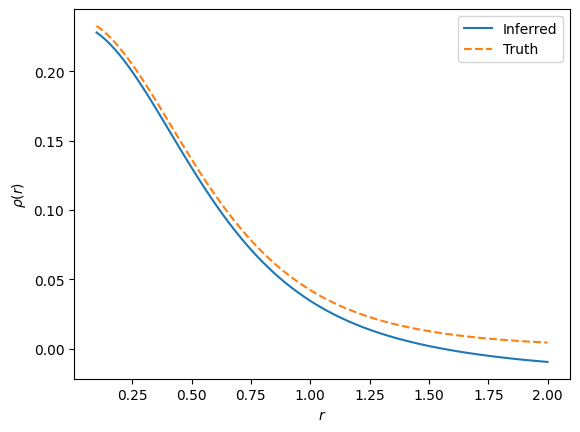

In [207]:
r_ary = np.linspace(0.1, 1. * pos.std(), 100)
plt.plot(r_ary, [rho_poisson_radial(r) for r in r_ary], label=r"Inferred")
plt.plot(r_ary, [rho_plummer(r, a=1.) for r in r_ary], label=r"Truth", ls="--")
plt.xlabel(r"$r$")
plt.ylabel(r"$\rho(r)$")
plt.legend()

## Red is learned phase-space, blue is samples from Plummer

##

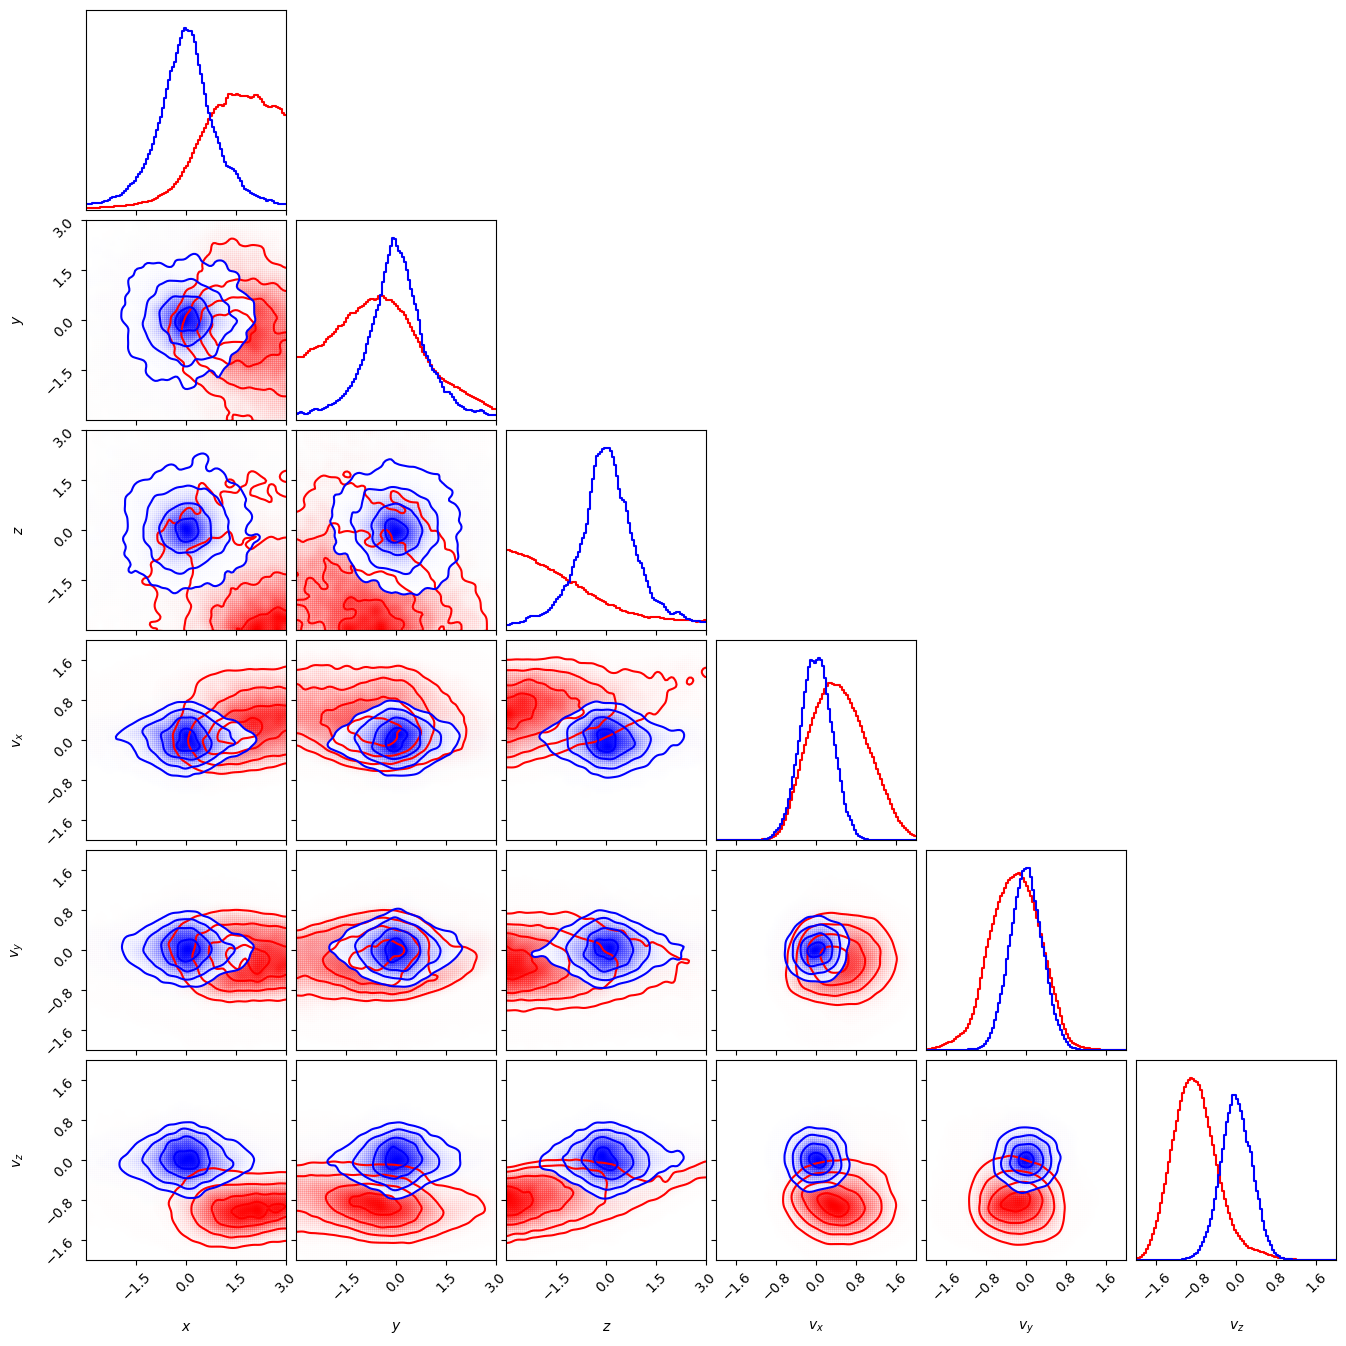

In [208]:
import corner

base_dist = tfd.MultivariateNormalDiag(loc=xv_mean, scale_diag=xv_std)
xv_samples_base = base_dist.sample(sample_shape=(n_samples,), seed=rng)

pos_samples_base, vel_samples_base = xv_samples_base[:, :n_dim], xv_samples_base[:, n_dim:]

dt = T / n_leapfrog_steps

def body_fn(i, z):
    pos, vel = z
    t = np.atleast_1d(i * dt)
    return jax.vmap(leapfrog_step, in_axes=(0,0,None,None))(pos, vel, lambda x: potential_mlp.apply(params, x, t)[0], dt)

# Phase space coordinates in the base distribution
pos_samples, vel_samples = jax.lax.fori_loop(lower=0, upper=n_leapfrog_steps, body_fun=body_fn, init_val=(pos_samples_base, vel_samples_base))

xv_samples_phase = np.concatenate([pos_samples, vel_samples], axis=-1)

plot_args = {"range": [(-3, 3), (-3, 3), (-3, 3), (-2, 2), (-2, 2), (-2, 2)], "bins": 100, "smooth": 2., "smooth1d": 1., "plot_datapoints": False, "plot_density": True}

# Plot two datasets on the same corner plot
fig = corner.corner(onp.array(xv_samples_phase), labels=[r"$x$", r"$y$", r"$z$", r"$v_x$", r"$v_y$", r"$v_z$"], color="red", alpha=0.5, **plot_args);
corner.corner(onp.array(xv_samples), labels=[r"$x$", r"$y$", r"$z$", r"$v_x$", r"$v_y$", r"$v_z$"], color="blue", alpha=0.5, fig=fig, **plot_args);